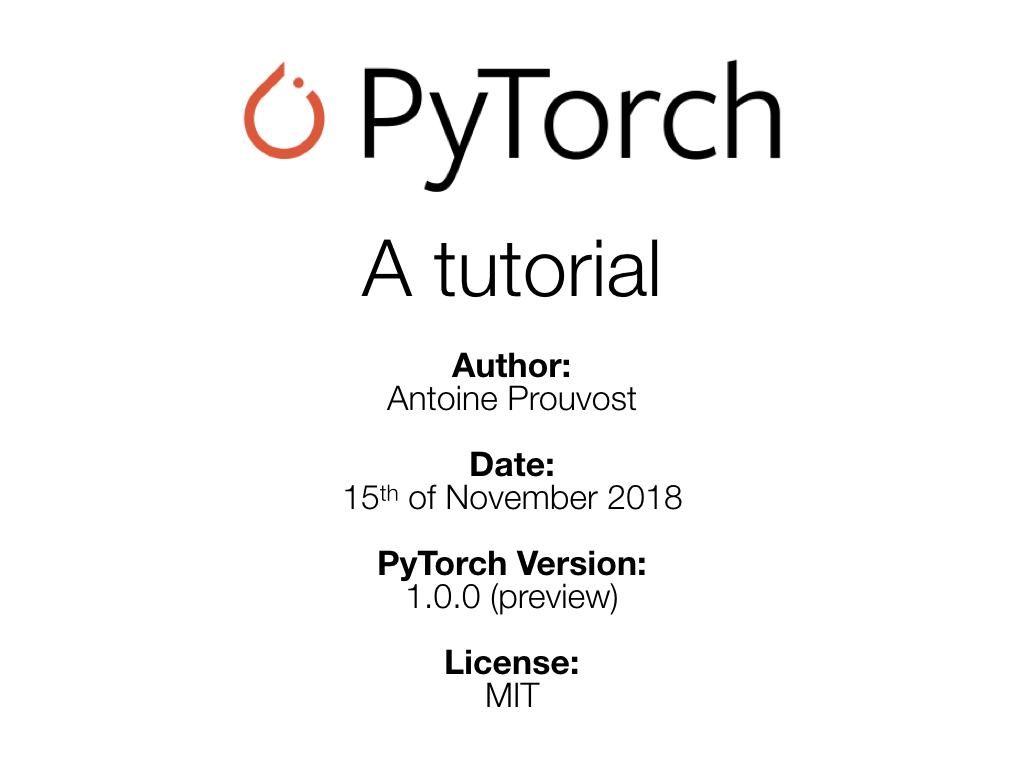

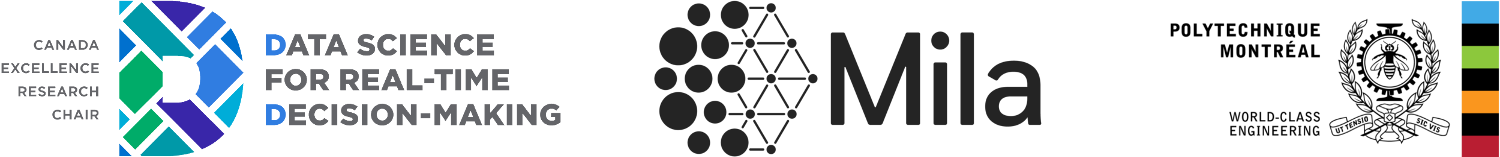

[Pytorch](http://www.pytorch.org) is a deep learning framework for modeling and training neural networks, with possible GPU acceleration. It is a very flexible framework with a Python-first interface that is executed dynamically (operations are done when the python instruction is executed) as opposed to other compiled system such as [TensorFlow](https://www.tensorflow.org/).
  
The outline of this tutorial is going to be as follows:
  - [1]  [Link to numpy](#1.-Link-to-numpy)
  - [2]  [GPU acceleration](2.-GPU-acceleration)
  - [3]  [Automatic differentiation](#3.-Automatic-differentiation)
  - [4]  [Api for neural networks](#4.-Api-for-neural-networks)
      - [4.1]  [Data and dataloader](#4.1-Data-and-dataloader)
      - [4.2]  [Models](#4.2-Models-(the-actual-neural-network))
      - [4.3]  [Optimizers](#4.3-Optimizers)
  - [5]  [Some good practices](#5.-Some-good-practices)
  - [6]  [Exercice (MNIST)](#6.-Exercise:-training-a-neural-network-for-digit-recogintion)
  - [7]  [Going further](#7.-Going-further)


## Prerequisites

You need to know some basics about python, numpy, machine learning, and deep learning.
For conprehensive introduciton to deep learning, I recommend [this series of videos](https://www.youtube.com/watch?v=bxe2T-V8XRs) and [this one](https://www.youtube.com/watch?v=aircAruvnKk) but of course there are __many__ other ressources onlines.
  - You can find the PyTorch documentation [here](https://pytorch.org/docs/)
  - Some tutorials [here](https://pytorch.org/tutorials/);
  - And the discussions [here](https://discuss.pytorch.org/).
  
## Notebook configuration
This notebook is hosted on [Github](https://github.com/ds4dm/tipsntricks/blob/master/pytorch/tutorial.ipynb) under MIT license. You can get a nicer display using [jupyter nbviewer](http://nbviewer.jupyter.org/github/ds4dm/tipsntricks/blob/master/pytorch/tutorial.ipynb).

### Locally
You can run this notebook locally using Python >= 3.6, and an installation of PyTorch. You can use PyTorch without GPU (all the functionalities are supported on CPU), however if you want GPU accleleration for you computation, you need an Nvidia GPU, CUDA, and CUDNN. Installation details are not provided in this tutorial.

### On Google Collaboratory
<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="right">

We'll run the notebook on Google Colaboratory. This is Google drive's jupyter notebbok tool. It runs automatically on Google servers and we can also access a GPU, all with very little configuration.
You can save file and install anything on the virtual machine, but the machine **will be killed** after some time. Be sure to download files that you want to keep (there are none in this tutorial).

Open this notebook in Colaboratory [here](https://colab.research.google.com/github/ds4dm/tipsntricks/blob/master/pytorch/tutorial.ipynb).

After opening go to `Runtime`>`Change runtime type` and select `Python3` and `GPU`.
It is important to do this **before** runing the installation cell bellow.

The following cell install Pytorch for us:

In [ ]:
# Install Pytorch
!pip3 install numpy torchvision-nightly torch_nightly \
    -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

--------
<img align="right" width="150" src="https://numfocus.org/wp-content/uploads/2016/07/numpy-logo-300.png" />
<h2>1. Link to numpy</h2>

Compiled executions graph such as TensorFlow enable some optimization of the computations, but PyTorch remains highly efficient, with underlying operations being done in low level languages (C, Cuda). In parctice, being dynamic means that PyTorch will behave like numpy. As for numpy, we take advantage of grouped operations by making them over an `array`. In PyTorch, we call them `tensor` but they behave similarly.

In [1]:
import numpy as np
import torch

We are using Pytorch version 1.0 preview.

In [2]:
torch.__version__

'1.0.0.dev20181029'

In [3]:
X = torch.tensor([[1, 2], [3, 4]])

In [4]:
# @ is matrix multiplication
X @ X + X

tensor([[ 8, 12],
        [18, 26]])

Tensors collapsed to numpy array naturally, so they can be used in numpy. We can also explicitely convert from and to numpy:

In [5]:
X_np = X.numpy()
X_np

array([[1, 2],
       [3, 4]])

In [6]:
Y_np = np.arange(5)
Y = torch.from_numpy(Y_np)

Beware that using any of these two functions, both and `X` and `X_np`, `Y` and `Y_np` share the same underlying memory. An example of what this means:

In [7]:
Y[3] = -1

In [8]:
Y_np

array([ 0,  1,  2, -1,  4])

This is to make efficient use of both frameworks together without having to copy the data every time. For creating a new object with a copy of the memory, simply use `np.array` and `torch.tensor`:

In [9]:
torch.tensor(Y_np)

tensor([ 0,  1,  2, -1,  4])

In [10]:
np.array(Y)

array([ 0,  1,  2, -1,  4])

<div class="alert alert-success">
<strong>Transfer to numpy</strong>:
    <ul>
        <li>With the <strong>same</strong> memory: use <code>.numpy()</code> and <code>torch.from_numpy</code></li>
        <li>With <strong>different</strong> memory: use <code>np.array</code> and <code>torch.tensor</code></li>
    </ul>
</div>

Tensor can be converted to different data types:

In [11]:
Y.float()

tensor([ 0.,  1.,  2., -1.,  4.])

This returns a new tensor with 32 bit floating point data.

<p class="alert alert-success">
The most used are <code>.float()</code>, <code>.int()</code>, <code>.long()</code>, and <code>byte()</code>. One can also use the more general <code>.type(torch.int64)</code> with any given type from PyTorch. We can query the type of <code>tensor</code> using <code>tensor.dtype</code>.
</p>

Overall, PyTorch is less rich than numpy in the collections of functions it implements and less flexible in the the convertion of data types.

In [12]:
# Cannot add ints and floats
try:
    X + X.int()
except RuntimeError as e:
    print(e)

TensorIterator expected type torch.LongTensor but got torch.IntTensor


To find the name of the functions implemented try your best guess, read the documentation, or search other ressourses online.

<hr>
<img width="300" align="right"
    src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/NVIDIA-GTX-1070-FoundersEdition-FL.jpg/2560px-NVIDIA-GTX-1070-FoundersEdition-FL.jpg" />
<h2>2. GPU acceleration</h2>

[GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit) are processing units with many core able to do small simple operations and a very fast access to its own memeory. We can use it to parallelize our `tensor` operations such as linear algebra. Neural networks make heavy use of tensor operations and get a nice speedup. Most of the PyTorch functions can be executed on GPU.

Initailly GPU where only intended for _graphical_ processing. With deep learning, GPU for general computing are on the rise, with [Nvidia](https://www.nvidia.com/en-us/) dominating the market. This is because of its propietary [CUDA](https://en.wikipedia.org/wiki/CUDA) that let programming its GPUs in an efficient fashion. Now all deep learning frameworks run on CUDA. You need to get an Nvidia GPU and install CUDA (+ CUDNN) if you want to get your own hardware. This may explain the correltation of Nvida stock price with deep learning interests (along with cryptocurrencies that also use GPUs):

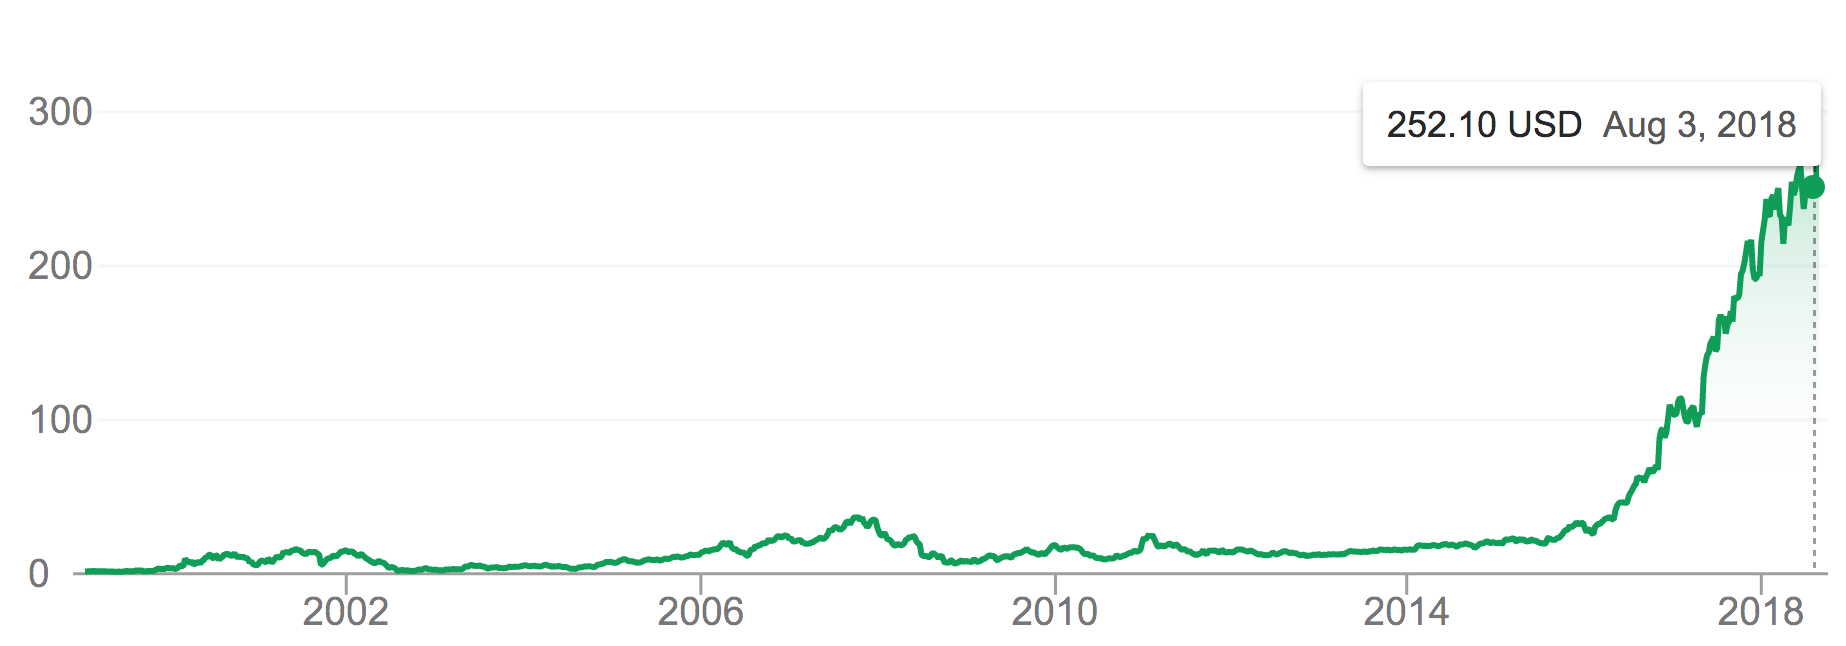

Hopefully we'll eventually get frameworks that are hardware independ, maybe using [OpenCl](https://en.wikipedia.org/wiki/OpenCL) as is done in [PlaidML](https://github.com/plaidml/plaidml).

First let's start by seeing if we have GPUs availables, and the number

<p class="alert alert-success">
We use <code>torch.cuda.is_available()</code> to know if there are Cuda compatible GPUs and <code>torch.cuda.device_count()</code> to know the how many of them.
</p>

In [13]:
torch.cuda.is_available()

True

In [14]:
torch.cuda.device_count()

1

To do computation on a GPU, we need to have a tensor in the memory of that GPU, which is not the same across different GPUs, and not the same as the CPU RAM. Once this is done, computation will happen naturally on the associate device.

<div class="alert alert-success">
    <p>
    To get a copy of a <code>tensor</code> on a GPU, we'll just use <code>tensor.to(device)</code> where device is:
    <ul>
        <li>An int for the index of the GPU;</li>
        <li><code>Eventually "cuda:0"</code> for the GPU here the index <code>0</code>;</li>
        <li><code>"cpu"</code> for the RAM/ CPU computing;</li>
        <li>A <code>torch.device</code> object that is just a wrapper around the above.</li>
    </ul>
    Alternatively, <code>tensor.to()</code> can also be used
    <ul>
        <li>With a <code>torch.dtype</code> to do return a <code>tensor</code> in another type;</li>
        <li>With a <code>tensor</code> to get a copy of the original <code>tensor</code> on the same device and with the same type as the <code>tensor</code> passed as argument.</li>
    </ul>
    </p>
    <p>
    We use <code>tensor.device</code> to qurey the device of a <code>tensor</code>.
    </p>
</div>

In [15]:
X = torch.tensor([[1., 2.], [3., 4.]])

In [16]:
X_cuda0 = X.to("cuda:0")

In [17]:
X.device

device(type='cpu')

In [18]:
X_cuda0.device

device(type='cuda', index=0)

In [19]:
# Computation done on GPU, result tensor is also on GPU
X_2 = X_cuda0 @ X_cuda0

In [20]:
X_2

tensor([[ 7., 10.],
        [15., 22.]], device='cuda:0')

We cannot do cross devices opertions:

In [21]:
try:
    X + X_cuda0
except RuntimeError as e:
    print(e)

TensorIterator expected type torch.FloatTensor but got torch.cuda.FloatTensor


Operations done on a GPU are asynchonous. Operations on a device are enqueued to be performed in the order specified  this allow to fully leverage devices at the same time. This is transparent to the user because synchonization operations are done when required: moving a `tensor` from on device to another (including printing). In practice, this means that if your put a cpu opeartion in the middle of your netwok, you will not fully utilize your CPU and GPU.

There are other ways to manage the device on which computation is done, including `tensor.cuda(device)` and `tensor.cpu()` but `tensor.to(device)` is the more generic and let us write device agnostic code by simply changing the value of the `device` variable.

It is also possible to create a `tensor` directly on a specific device, but this is limited to zeros, ones, and random initialization. This is for more advanced cases that we won't need.

More information can be found in the [documentation](https://pytorch.org/docs/stable/notes/cuda.html).

### [Advanced] Sharing GPUs

Using PyTorch you cannot share a GPU with other processes. If you share a machine with multiple GPUs with other users without a job scheduler, you might end up getting conflict situtation.

Your PyTorch code should always assume contiguous GPUs indexes starting from 0. Then, when running your job, GPU 0 may not be available (run `nvidia-smi` to see GPU availability). You would then run your code with the environement variable `CUDA_VISIBLE_DEVICES` set to the GPUs you want to use, for instance `CUDA_VISIBLE_DEVICES=2` to use only GPU 2 and `CUDA_VISIBLE_DEVICES=1,3` to use GPU 1 and 3. In PyTorch you will see them as 0, 1,... It will also adjust the result from ` torch.cuda.device_count()` _etc_.

--------
## 3. Automatic differentiation

Pytorch is able to numerically compute gradients using reverse mode [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), aka _backprop'_ for the cool kids and _chain rule_ for the boring ones. To do so, it keeps track of the computation done using a computation graph (built _dynamically_).

Computing derivatives in reverse mode requires remembering the [jacobians](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), which is memory intensive (and computationally intensive if the derivatives are more complex, but in the case of neural networks they can be usually extracted for free from the forward computations).

PyTorch computes the derivates only where required, which is set to nowhere by default.

In [22]:
import torch
import torch.autograd as autograd

In [23]:
X = torch.tensor([1, 2, 3], dtype=torch.float32)
l2_norm = X.norm()

In [24]:
try:
    # Gradient of the l2_norm of X, with respect to X
    autograd.grad(l2_norm, X)
except RuntimeError as e:
    print(e)

element 0 of tensors does not require grad and does not have a grad_fn


Indeed, we did not specify that `X` was to require a gradient:

In [25]:
X.requires_grad

False

To specify that `X` will require a gradient, we need to specify it using the attribute `.requires_grad`. This let PyTorch know that we want to compute gradient with regard to this variable and that it should do what is necessary in order to do so.

In [26]:
X.requires_grad = True
l2_norm = X.norm()

In [27]:
# Gradient of the l2_norm of X, with respect to X
autograd.grad(l2_norm, X)

(tensor([0.2673, 0.5345, 0.8018]),)

<img width="300" src="https://i.kym-cdn.com/photos/images/original/000/085/444/1282786204310.jpg" />

Note that all `tensor` that depend on `X` also need to recieve a gradient for the backpropagation to work, so PyTorch will set them automatically:

In [28]:
l2_norm.requires_grad

True

Also note that after backpropagating, PyTorch will free the computation graph, so we cannot reuse it as is.

In [29]:
try:
    # Try to backpropagate throught the graph a second time
    autograd.grad(l2_norm, X)
except RuntimeError as e:
    print(e)

Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.


The gradients are often computed in a object oriented mode using `.backward()`. This will computed the gradients of everything in the computation graph that has `requires_grad=True`. The gradients are stored in the `.grad` attribute of the `tensor`. That way they will be accessed for the gradient descent without having to scpecify all the gradients one by one.

In [30]:
X = torch.tensor([1, 2, 3], dtype=torch.float32)
X.requires_grad = True
l2_norm = X.norm()

In [31]:
l2_norm.backward()
X.grad

tensor([0.2673, 0.5345, 0.8018])

To reuse a piece of code without storing unecessary jacobians, we can use the following context manager (piece of code that start with the `with` keyword). This is convenient to use a neural network without further training. The context manager will let us reuse the extact same code during training and inference.

In [32]:
X = torch.tensor([1, 2, 3], dtype=torch.float32)
X.requires_grad = True

with torch.no_grad():
    try:
        X.norm().backward()
    except RuntimeError as e:
        print(e)

element 0 of tensors does not require grad and does not have a grad_fn


We can also use `detach()` to disconnect the computation graph

In [33]:
X = torch.tensor([1, 2, 3], dtype=torch.float32)
X.requires_grad = True

# Gradient of square norm of X
autograd.grad(X.norm() * X.norm(), X)

(tensor([2., 4., 6.]),)

In [34]:
X = torch.tensor([1, 2, 3], dtype=torch.float32)
X.requires_grad = True

# Gradient of norm of X, time norm of X
autograd.grad(X.norm().detach() * X.norm(), X)

(tensor([1., 2., 3.]),)

Overall the default PyTorch mecanisms are defined according to how gradients are used in neural networks. If you want to know more about automatic differentiation in PyTorch you can look at [this tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

------------
## 4. Api for neural networks

Recall that if $f_\theta$ is a neural network parametrize by $\theta$ (the weights), we optimize over $\theta$ so that the network behave properly on the input points. More precisely, we have a loss function per-example $\mathcal{L}$ (e.g. [categorical cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) for [classification](https://en.wikipedia.org/wiki/Statistical_classification) or [mean square error](https://en.wikipedia.org/wiki/Mean_squared_error) for [regression](https://en.wikipedia.org/wiki/Regression_analysis)) and want to minimize the [generalization error](https://en.wikipedia.org/wiki/Generalization_error):

$$
    \min_{\theta} \mathbb{E}_{x, y} \mathcal{L}(f_{\theta}(x), y) 
$$

Where $x$ and $y$ follow the unknown true distribution of data. To make it tracktable, we approxiamte this loss by the empirical training error (on the training data):

$$
    \min_{\theta} \frac{1}{N}\sum_{i=0}^{N} \mathcal{L}(f_{\theta}(x_i), y_i) 
$$

Because computing $f_\theta(x_i)$ and $\nabla_\theta f_\theta(x_i)$ for every $i$ is expensive, we compute it on a subset of the data points to make a gradient descent step over $\theta$. This is known as the [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) algorithm. It is stochastic from the fact that we compute the gradient of the loss function only over a mini batch.

The points sampled to estimate the gradient are known as the batch (or mini batch) and it size is the `batch_size`. We change the batch after every gradient step.
We usually sample without replacement. Once all the points have been sampled, we start again a new loop. This is known as an `epoch`.

We monitor the loss on a validation set during training and evaluate the final model on a test set.

If the model is not able to fit the training data, its capacity is too low and the model is said to underfit. If it fits the data nicely but do not generalize to unseen examples, the model is said to [overfit](https://en.wikipedia.org/wiki/Overfitting) and [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) can be used to mitigate it.

### 4.1 Data and dataloader

In machine learning we represent our input points in a higher dimension tensor, where the first (usual convention) dimension is the index, other are features dimensions. For instance, if we have data for predicting the price of an appartment

| size   | downtown | renovated | parking |
|--------|----------|-----------|---------|
| 30     | false    | true      | true    |
| 10.4   | false    | true      | false   |
| 50     | true     | false     | true    |

And the target vector

| price |
|-------|
| 89.6  |
| 56    |
| 10    |


Would be represented as:

In [35]:
X = torch.tensor([
    [30,   0, 1, 1],
    [10.4, 0, 1, 1],
    [50,   1, 1, 1]
])
Y = torch.tensor([89.6, 56, 10])

In the case of `y`, the second dimension (`dim=1`) has only one feature (the price) so we don't need to add a second axis for the vector.

Depending on the application, the features dimensions can be organised in more than one dimension to better use the structure. For instance, if we had images, we would have two features axis, hence havinga three dimensional tensor `0: index`, `1: x-axis`, and `2: y-axis`. If we had movies, we would have a four dimensional tensor `0: index`, `1: x-axis`, and `2: y-axis`, `3: time`. More advanced structured inputs (sequences, graphs, ...) require more carefully designing the tensor.

In traditional machine learning, we can pass the whole `X` and `y` tensor to an algorithm ([linear regression](https://en.wikipedia.org/wiki/Linear_regression), [random forrest](https://en.wikipedia.org/wiki/Random_forest), [SVM](https://en.wikipedia.org/wiki/Support_vector_machine)). In deep learning, we have way more inputs and use stochastic gradient descent.

A pseudo code for a simple gradient descent would look like the following.
```python
for epoch in range(max_epoch):
    n_batchs = X.size(0) // batch_size + 1
    for i in range(n_batchs):
        X_batch = X[i*batch_size: (i+1)batch_size]
        y_batch = y[i*batch_size: (i+1)batch_size]
        
        ##### Detailed later
        # compute predictions
        # compute loss
        # compute gradients
        # apply gradient step
```
Notice we didn't truly go through the truble of sampling properly. We just assume the matrix is shuffled and reuse the same order (in practice that doesn't change much).

PyTroch introduces the `Dataset` and `DataLoader` classes to do that work. The idea behind the dataloader is that in even the data might not hold in memory (or GPU memory) and will load it only as necessary. Even when that is not an issue, the dataloader will come handy in order no to rewite the for sampling datapoints.

**Note**: in neural networks, we use `float` to reresent the data, even if it is integer, because we want to do operation with the weights, which are floats.

#### Dataset

<p class="alert alert-success">
The <code>Dataset</code> class is just a representation of our data. We have to implement the <code>__len__</code>(number of examples) and the <code>__getitem__</code> (return the example number <code>i</code>, doesn't need to support <code>slice</code>).
</p>

In [36]:
from torch.utils.data import Dataset


class MyDataset(Dataset):

    def __init__(self, X, Y):
        assert len(X) == len(Y)
        self._X = X
        self._Y = Y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, i):
       return self._X[i], self._Y[i]

We can use it with our data:

In [37]:
ds = MyDataset(X, Y)
ds[0]

(tensor([30.,  0.,  1.,  1.]), tensor(89.6000))

One can use the opportunity of the `Datatset` class to read example from disk, either one by one in `__getitem__`, or all at once in `__init__`. It can also be used to generate new one one the flight.

In the case of simpe `tensor` it is so straightforward that the is a factory function to do it the previous dataset:

In [38]:
from torch.utils.data import TensorDataset

ds = TensorDataset(X, Y)
ds[0]

(tensor([30.,  0.,  1.,  1.]), tensor(89.6000))

#### DataLoaders

<p>
<div class="alert alert-success">
<p>
The <code>DataLoader</code> combines a <code>Dataset</code>, a a <code>Sampler</code>, and a bacthing function <code>collate_fn</code> to form batches ready to use by the neural network.
</p>
<p>
The sampler represents the sampling strategy, it outputs indexes passed to the <code>Dataset</code>. In practice, it can be constructed automatically by the <code>DataLoader</code>.
<ul>
<li>
The <code>collate_fn</code> takes mutliple examples anf form a batch. In most case this is simply concatenating but it can be changed for more advaned behaviors.
</li>
<li>
The <code>DataLoader</code> also has other useful paramters such as the number of workers. All is explained in the <a href="https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader">documentation of the function</a>.
</li>
</ul>
</p>
</div>
</p>

In [39]:
from torch.utils.data import DataLoader

data_loader = DataLoader(ds, batch_size=2, shuffle=True)

for epoch in range(3):  # epoch loop
    print(f"Epoch: {epoch}")
    for batch in data_loader:  # mini batches loop
        x, y = batch
        print("\t", y)

        # compute loss and gradients

Epoch: 0
	 tensor([10.0000, 89.6000])
	 tensor([56.])
Epoch: 1
	 tensor([89.6000, 10.0000])
	 tensor([56.])
Epoch: 2
	 tensor([56.0000, 89.6000])
	 tensor([10.])


We see that the dataloder exposed served the batch (of size 2) one by one in a random order (reshuffling between the three epochs. The last bacth of every epoch is of size 1 because they weren't enough example to form a full mini-batch. That is usually not a problem but can be controlled with the `drop_last` option of the `DataLoader`.

In this section we showed how mini-batches are handled in deep learning and presented the Pytorch conviniet way of iterating through them. Using them is optional but reduce the amount of code to write.

Famous deep learning dataset come with their own class that download the data on the first use, save it to disk, and read it.

More information on data loading can be found in [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

### 4.2 Models (the actual neural network)

<img width="300"
     src="https://upload.wikimedia.org/wikipedia/commons/3/30/Multilayer_Neural_Network.png"
/>

In a feed forward neural networks, we alternate between layers of different sizes. More complex networks have more complex operations (convolutions, recurrent, gated, attention, stochastic, ...), but in the end, we represent everything as a _layer_.
For instance we will say that a matrix multiplication is a `Linear` layer, that an elementwise non linearity (such as `ReLU`) is another.

In PyTorch, we will call our layers and networks `Module`s. A `Module` can be a layer or a mix of other `Module`s.
You can write a `Module` to do many things as long as it can be expressed in PyTorch and that a gradient can be computed or estimated.

<p class="alert alert-success">
In PyTorch, all layers and models are instance of the same class <code>Module</code>. This is because just one layer can be a neural network; and combining neural networks also makes a neural network.
</p>

In the following, remember that a `Module` (a layer or a neural network) is just a sucession of operations, or simply a function. The goal of the `Module` class is simply to keep track of some objects and to interfact seamlessly with the rest of PyTorch.

Let's make a simple feed forward neural network with a couple of `Module` (or layers).

In [40]:
import torch
import torch.nn as nn


model = nn.Sequential(
    nn.Linear(4, 20),   # from 4 input neurons to 20 hidden neurons
    nn.ReLU(),          # an elementwise non-linearity
    nn.Linear(20, 20),  # this is a `Module`
    nn.ReLU(),          # this is also a `Module`
    nn.Linear(20, 1)    # output layer as one neuron for our regression
)

That's a neural network with two hidden layers, each of one having 20 neurons. The input layer has 4 entries (that was the number of features of our `X`), that mean that we need a linear transformation mapping $\mathbb{R}^4$ to $\mathbb{R}^{20}$.

The whole network is a `Module`:

In [41]:
isinstance(model, nn.Module)

True

We can use it on our data:

In [42]:
model(X)

tensor([[0.7536],
        [0.1151],
        [1.3821]], grad_fn=<ThAddmmBackward>)

`Linear` and ` ReLU` are also `Modules`, and we can use them on some data as well:

In [43]:
issubclass(nn.Linear, nn.Module)

True

In [44]:
module = nn.Linear(4, 20)
module(X)

tensor([[  5.0859,   3.8919,  13.2171,   1.1617,   2.8037,  14.0522,   3.5196,
         -13.9624,  -5.6363,   1.2127, -13.6089, -10.8215,   2.8796,   9.0043,
          10.0359,   5.2621,  11.4059,  13.7530,   9.5558, -10.8165],
        [  1.5233,   1.3975,   4.9804,   0.7878,   0.6531,   4.9183,   0.9269,
          -5.0528,  -2.1014,   0.2337,  -4.1823,  -3.8349,   0.8036,   3.2967,
           3.7746,   2.3956,   4.0175,   4.1380,   3.4466,  -3.0694],
        [  9.1220,   6.2612,  22.0423,   1.3328,   5.3646,  23.2506,   6.5124,
         -22.9902,  -9.6296,   2.1880, -22.9751, -17.5899,   5.4803,  14.5453,
          16.3960,   8.1119,  19.0221,  23.5967,  15.2973, -18.3581]],
       grad_fn=<ThAddmmBackward>)

<p class="alert alert-success">
A <code>Module</code> has some methods that are the same as a <code>tensor</code>, such as <code>.to(device)</code>, <code>dtype(type)</code>, and <code>.float()</code>.
</p>

<p class="alert alert-success">
The class-oriented API is what you need to use to define more complex models. It let you define how to do the computation using the <code>.forward</code> method.
</p>

In [45]:
class MyModel(nn.Module):
    
    def __init__(self):
        # Initialize parent class, this is mandatory
        super().__init__()
        
        # Our previous network
        # Creating these modules initialize them with different 
        # weights. There are different object representing 
        # different variables.
        self.lin1 = nn.Linear(4, 20)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(20, 20)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(20, 1)
        
    # forwad is just the method name used by PyTorch.
    # The parent class of `Module` implements __call__
    # to call our `forward` but also needs to do some
    # extra work.
    def forward(self, X):
        # This is just some Pytorch computations.
        # Modules do Pytorch operations
        h = self.lin1(X)
        h = self.relu1(h)
        h = self.lin2(h)
        h = self.relu2(h)
        out = self.lin3(h)
        return out

There is no dark magic in the code above, it's simply a bunch of class initializing some `tensor`s, and then making some operations on the input `X`. Same forward computation could be written in numpy (but we're going to need to compute some gradients). This works the same as before

In [46]:
model = MyModel()
# The result is not supposed to be the same because
# our linear `Module`s are initialized randomly.
model(X)

tensor([[-1.1506],
        [-0.4492],
        [-1.8337]], grad_fn=<ThAddmmBackward>)

Actually there's bit more than just the `tensor` operations here. The reason why initialzing the `nn.Module` in the `__init__` is because PyTorch will keep track of all the `Module`s set as attributes of the object for us.
That way, when calling methods that need to operate on all submodules, such as `.float()` or `.to(device)` (or `.train()`, `eval()`, `parameters()`, `apply()` seen later), PyTorch can apply this method recursivly for us.

<div class="alert alert-success">
    When setting to a <code>Module</code> an attribute containing another <code>Module</code>, PyTorch will keep track of them to apply some methods <strong>recurively</strong>. The attribute <strong>must</strong> me a <code>Module</code> (not a list or dict of modules). However <code>nn.ModuleList</code> and <code>nn.ModuleDict</code> can be used to create a <code>Module</code> out of other <code>Module</code>s and behave like a <code>list</code> and <code>dict</code> respectively.
</div>

You're free to extend `nn.Module` the way you want, add other methods _etc._. You can have more parameters, options in `__init__` and `forward`. Usually you would put the size of you layers and other hyperparameters in your `__init__` arguments.

Notice how in `forward`, we just feed the result of the previous `Module` to the next one? That's exactly what the `Sequential` model from before does, it's just a shorthand.

Let's dig deeper. Our `ReLU` doesn't have any parameters, so we don't need to keep track of it, we could simply have only one:

In [47]:
class MyModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(4, 20)
        self.lin2 = nn.Linear(20, 20)
        self.lin3 = nn.Linear(20, 1)

    def forward(self, X):
        h = self.lin1(X)
        h = self.relu(h)
        h = self.lin2(h)
        h = self.relu(h)
        out = self.lin3(h)
        return out

Or even:

In [48]:
class MyModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.lin1 = nn.Linear(4, 20)
        self.lin2 = nn.Linear(20, 20)
        self.lin3 = nn.Linear(20, 1)

    def forward(self, X):
        h = self.lin1(X)
        h = torch.max(h, 0)
        h = self.lin2(h)
        h = torch.max(h, 0)
        out = self.lin3(h)
        return out

We can also replace the `torch.max` by a function of only one input

In [49]:
import torch.nn.functional as F

# Same as torch.max(X, 0)
F.relu(X)

tensor([[30.0000,  0.0000,  1.0000,  1.0000],
        [10.4000,  0.0000,  1.0000,  1.0000],
        [50.0000,  1.0000,  1.0000,  1.0000]])

In the case of ReLU, this just make the code slighly more readable, but other function that we'll use later are more and compicated. It's also an opportunity for the developpers to optimize the code behind.

You can have a look at the code for `Linear` [here](https://github.com/pytorch/pytorch/blob/2141cb7d53b337c85c516a21def67ed1d8e90838/torch/nn/modules/linear.py#L10) (it's not hard to read). You'll see that it's very alike our own `Module`. The class just initialize `Parameter`s in `__init__`, and use them to do the affine transformation in `forward` 

<p class="alert alert-success">
<code>F.linear</code> is just a function without internal <code>Parameter</code> that return <code>W @ X.t() + b</code>. This is known has the functional API, it achieves the same as the <code>nn.Module</code> API but in a stateless way (pure functions).
</p>

An other important aspect to keep in mind is whether the model is in training mode or evaluation mode. Certain `nn.Module` behave differently depending on the case. For instance, dropout is a regularization technique that will randomly put some output of a layer to zero. When the model is evaluated, all outputs are used (there is also a scaling so that the expectation stay the same at train ad test time).

`nn.Module` keep tracks of that for us. All we need to do is say which mode we want and it will propagate to all the `nn.Module` in our network.

<p class="alert alert-success">
We use <code>.train()</code> to put the model in training mode and <code>.eval()</code> to put it in evaluation mode. The <code>.training</code> attribute tells us in which mode the network is.
</p>

In [50]:
# Put `nn.Module` in train mode
model.train()
# Check if `nn.Module` is in training mode
model.training

True

In [51]:
# Put `nn.Module` in train mode
model.eval()
# Check if `nn.Module` is in training mode
model.training

False

If you use the functional API (`torch.nn.functional as F`) in you `.forward` method, you can pass `self.training` to the function that behave differently at train and test time.

In [52]:
# When using Dropout at train time, a scaling is applied
# to keep the same activation expactation downward.
F.dropout(X, training=True)

tensor([[  0.0000,   0.0000,   2.0000,   0.0000],
        [ 20.8000,   0.0000,   0.0000,   0.0000],
        [100.0000,   2.0000,   2.0000,   2.0000]])

In [53]:
# no dropout at evaluation time
F.dropout(X, training=False)

tensor([[30.0000,  0.0000,  1.0000,  1.0000],
        [10.4000,  0.0000,  1.0000,  1.0000],
        [50.0000,  1.0000,  1.0000,  1.0000]])

In our forward loop, applying dropout before the last layer would look like this:
```python
def forward(self, X):
    h = self.lin1(X)
    h = torch.max(h, 0)
    h = self.lin2(h)
    h = torch.max(h, 0)
    h = F.dropout(h, training=self.training)
    out = self.lin3(h)
    return out
```

#### [Advanced] Parameters

The neural netwok is a function of both its input $x$ and its parameters (or weights) $\theta$. We're gonna leave the internal weights for PyTorch to manage. That is the goal of the `Parameter` class. This class wraps a `tensor` to let PyTorch know that this tensor needs to be updated. That means both computing its gradient (`requires_grad=True`) but also making the gradient step
$\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}$.

To know what parameters to update, PyTorch will recursively look in your `Module` attributes for other `Module`, `Parameter` or sequences of the previous.

You need to use `Parameter` if you implement a very specific type of layer. If you make a network, you can just reuse the layer already available. Even we building new layers, it's often possible to reuse other layers.

Our `Linear` has some parameters (a linear matrix transformation and a bias vector, so actually an affine transformation) :

In [54]:
for p in nn.Linear(4, 20).parameters():
    print(p)

Parameter containing:
tensor([[-0.2329,  0.3054, -0.2253, -0.4675],
        [-0.3942, -0.3691, -0.4030, -0.0546],
        [-0.1314, -0.3859,  0.1121, -0.0501],
        [ 0.3440, -0.0636,  0.1625, -0.4109],
        [ 0.1639,  0.3913, -0.0290,  0.2469],
        [-0.4289,  0.3555,  0.3332,  0.0426],
        [-0.4402,  0.1229,  0.2273,  0.4738],
        [ 0.2105,  0.2493, -0.1135, -0.3707],
        [-0.1539,  0.1963, -0.4930,  0.2213],
        [ 0.1636,  0.4461, -0.0560, -0.1019],
        [ 0.2763, -0.0189,  0.3697, -0.2983],
        [-0.1593,  0.3479,  0.3386,  0.3868],
        [-0.0459,  0.3528, -0.2108,  0.2221],
        [-0.0482,  0.2490, -0.0182,  0.4515],
        [-0.4304, -0.0206,  0.5000, -0.1711],
        [ 0.2635,  0.4377, -0.2150,  0.2668],
        [ 0.1276,  0.1702,  0.1613, -0.4508],
        [ 0.4672, -0.3505,  0.2482,  0.4239],
        [-0.4131, -0.2773,  0.0688, -0.4276],
        [-0.1389, -0.3049,  0.4601,  0.4450]], requires_grad=True)
Parameter containing:
tensor([-0.0717

If you re-execute, you will see different values, that is because it's a different object. If you want to tie weights in you network, you can reuse the same `Module` object.

`ReLU` doesn't have any parameters:

In [55]:
for p in nn.ReLU().parameters():
    print(p)

Our model has all the parameters of its submodules because this method is recursive. Let's print only __one__:

In [56]:
print(next(model.parameters()))

Parameter containing:
tensor([[-0.4668, -0.0013,  0.0107, -0.2961],
        [-0.1554, -0.3806, -0.3874,  0.2060],
        [-0.4973,  0.3846,  0.0891, -0.0271],
        [-0.1573,  0.1416, -0.3163,  0.1142],
        [-0.2116, -0.4687, -0.1867, -0.4332],
        [-0.0704, -0.3599, -0.4545, -0.3841],
        [ 0.1710, -0.1760, -0.2861, -0.1752],
        [-0.0458, -0.2593,  0.0201,  0.3894],
        [-0.3228,  0.2349, -0.3662, -0.3912],
        [-0.2560, -0.1320,  0.2487,  0.3214],
        [ 0.3086, -0.4938,  0.4587, -0.0428],
        [-0.0318,  0.3776, -0.0107, -0.3959],
        [-0.4124, -0.0660,  0.3169, -0.0089],
        [ 0.4680, -0.1402, -0.3238,  0.3217],
        [-0.1679,  0.2869,  0.3629,  0.0872],
        [ 0.2256,  0.2659,  0.1922,  0.1851],
        [-0.3673,  0.2606, -0.1690,  0.1336],
        [ 0.3187,  0.2899, -0.0908,  0.0631],
        [-0.3729, -0.4425, -0.0696,  0.4444],
        [-0.1875,  0.4014,  0.3557, -0.2565]], requires_grad=True)


A good practice is to define a function to initialize the Parameters of the module. However, we cannot apply an initialization inplace directly, this is because the tensors in `Parameter`s have `reauires_grad=True`:

In [57]:
# `.weight` is the name of the attribute used in
# the `Linear` layer. There is also `.bias`.
# This may be is different for other layers with `Parameter`s.
lin = nn.Linear(3, 3)
lin.weight

Parameter containing:
tensor([[-0.5454, -0.2030, -0.2144],
        [ 0.1349, -0.4686, -0.0555],
        [ 0.0593,  0.5066, -0.5609]], requires_grad=True)

In [58]:
try:
    lin.weight[:] = 0
except RuntimeError as e:
    print(e)

Instead, we're going to do the operation on the underlying `tensor` `.data`. This `tensor` exists for all `tensor`s (not specific to `Parameter`). This `.data` `tensor` share the memory with the main `tensor` but does not have any `autograd` mecanisms.

In [59]:
lin.weight.data

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [60]:
lin.weight.data.requires_grad

False

In [61]:
lin.weight.data[:] = 0
lin.weight

Parameter containing:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<CopySlices>)

<p class="alert alert-success">
    The <code>Module.apply</code> method let us apply a function on every module (hence submodule) in a <code>Module</code>. To write a initialization function, we can used the initializations provided in <code>torch.nn.init</code>
</p>

Remember, that the function will be given all, module, including the main one, so we hae to filer for the submodules that we wish nto act on.

In [62]:
def my_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [63]:
model.apply(my_init)

MyModel(
  (lin1): Linear(in_features=4, out_features=20, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=20, out_features=1, bias=True)
)

Calling `.apply(func)` is the same as doing:

In [64]:
for m in model.modules():
    my_init(m)

#### State and serialization

Getting a frozen copy of your model and being able to save it to the disk is important for many reasons
  - Once you ahe trained a model, you want to store it and use it on some task;
  - During training, you want to keep the model (`Parameter`s) performing the best on the validation set;
  - During long training, you want to be able to restore your optimization in case the jobs gets killed (especially useful on cluser with low priority computing).

<div class="alert alert-success">
    <p>
    The method <code>.state_dict()</code> of a <code>Module</code> will return a dictionary with all inside information necessary to recover the state of the model (mostly the value of inner <code>Parameters</code>. The method <code>.load_state_dict(dict)</code> will load that state 
    </p>
    <p>
    The method <code>torch.save</code> can be used to serialized (save to disk) torch objects. We can pass it the result from <code>.state_dict()</code>. Similarilly, the method <code>torch.load</code>
    </p>
</div>

It is possible to used the `pickle` module directly on torch objects (open file as binary). It is also possible to serialize the whole `Module` class instead of the its state, but there are some [caveats](https://pytorch.org/docs/stable/notes/serialization.html?highlight=recommend%20saving%20models).

<p class="alert alert-danger">
The state returns by <code>.state_dict()</code> shares an underlying memory with the <code>Module</code> <code>Parameter</code>s. This mean if you keep the states in python, they will keep changing as you optimize your model. To avoid that, you can save them to disk or make a deep copy the <code>deepcopy</code> from the <code>copy</code> python module.
</p>

In [65]:
lin = nn.Linear(3, 3)
state = lin.state_dict()
state

OrderedDict([('weight', tensor([[ 0.5340, -0.0810, -0.1926],
                      [ 0.3295,  0.4433, -0.2369],
                      [-0.4661, -0.0186, -0.0389]])),
             ('bias', tensor([-0.5679, -0.4455,  0.2655]))])

In [66]:
# Our state and `Module` parameters are linked.
state["weight"][:] = 0
lin.weight

Parameter containing:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)

We use it the following way:

In [67]:
lin = nn.Linear(3, 3)
# Save state dict.
torch.save(lin.state_dict(), "/tmp/my_model_state")

In [68]:
# Modify model.
lin.weight.data[:] = 0
lin.weight

Parameter containing:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)

In [69]:
# Reload the parameters.
lin.load_state_dict(torch.load("/tmp/my_model_state"))
# Parameters recovered:
lin.weight

Parameter containing:
tensor([[ 0.3508,  0.0524, -0.5288],
        [-0.3937, -0.5125,  0.0456],
        [ 0.2868, -0.0249,  0.2399]], requires_grad=True)

#### Moving a model to GPU
Because a `torch.nn.Module` holds `Pararameter`s (which are `tensor`s), it is important to move the model on the device on which we want to do our computations.

<p class="alert alert-success">
Use <code>model.to(device)</code> to move the <code>nn.Module</code> on the given device. Compared to <code>tensor.to(device)</code> this function moves the current model on the device and returns itself.
</p>

### 4.3 Optimizers

<img width="200" src="https://upload.wikimedia.org/wikipedia/commons/7/79/Gradient_descent.png" />

Now that we have an api for neural networks and automatic gradients computation for the parameters, gradient descent is going to be as easy as $\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}$.

Pytorch provides different optimizer that inherits from the `torch.optim.Optimzer` base class. The most simple one is `optim.SGD` which does exactly the update mentioned previously. `optim.Adam` (ref [here](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) is a nice go-to optimizer.

To instantiate an optimizer, we need to give it the parameters to optimize over, as well as optimization parameters. Thankfully, we've seen how to get all the parameters in our `nn.Module`.

<p class="alert alert-success">
    To create an optimizer, choose an algorithm from <code>torch.optim</code> and pass it the model parameters (<code>torch.nn.Module.parameters</code>), along with other hypermarameters (learning rate...).
</p>

<p class="alert alert-danger">
    If you move your model to another device (a GPU), be sure to do so <strong>before</strong> giving the parameters to the <code>Optimizer</code>
</p>

More information on optimizer is available in the [documentation](https://pytorch.org/docs/stable/optim.html).

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [71]:
# lr is learning rate, a very important hyperparameter
optimizer = optim.Adam(model.parameters(), lr=1e-3)

**Note**: that there is a `weight_decay` ($\mathcal{l}_2$ norm regularization) parameter in optimizer. This is a shorthand, that way, one doesn't need to list all the parameters in the loss function. Be careful, usually one does not regularize biases of the model.

To write an optimization step we use two functions from `torch.optim.Optimizer`.

<p class="alert alert-success">
We need <code>optimizer.zero_grad()</code> to reset the <code>.grad</code> attribute of our parameters to zero (otherwise they would be sum, this is a feature required by backpropagation). Then compute new gradients, and use <code>optimizer.step()</code> to perform a gradient update.
</p>

In [72]:
# This is going to make sure all `.grad` attribute
# in the tensor parameters of our network are reset
# to zero.
# Otherwise, as we keep computing gradients, they
# are summed in this `.grad` attribute.
optimizer.zero_grad()

# Forward pass
y_pred = model(x)

# Compute loss between the predictions of the true labels.
# Here we use the mean square error for regression.
# Note: y_pred had dimension `batch_size x 1`, when y has only
# size `batch_size`. We use `squeeze` to remove the 1-dimensions.
# We could also have added `squeeze` at the end of our `.forwad`
# method.
loss = F.mse_loss(y_pred.squeeze(1), y)

# Compute the gradients of the parameters in the compute
# graph
loss.backward()

# the optimizer apply a descent step to the parameters
optimizer.step()

**Note**: the optimizer are **always minimizing**, if you want to maximize, you can take the negative of your loss.

Overall, once we've created our model (`nn.Module`), our `Dataset`, our `Dataloader`, and our `Optimizer` the training loop looks like this:

In [73]:
for epoch in range(6):  # epoch loop
    print(f"Epoch: {epoch}")
    for batch in data_loader:  # mini batches loop
        model.train()  # make sure the model is in training mode
        x, y = batch
        optimizer.zero_grad()
        y_pred = model(x)
        loss = F.mse_loss(y_pred.squeeze(1), y)
        loss.backward()
        optimizer.step()
        print("\t", f"Loss: {loss.item()}")

Epoch: 0
	 Loss: 3569.190185546875
	 Loss: 13222.5224609375
Epoch: 1
	 Loss: 8645.0615234375
	 Loss: 2545.50732421875
Epoch: 2
	 Loss: 3298.4873046875
	 Loss: 12665.0234375
Epoch: 3
	 Loss: 3173.71337890625
	 Loss: 12398.5810546875
Epoch: 4
	 Loss: 8155.9658203125
	 Loss: 1976.7020263671875
Epoch: 5
	 Loss: 6950.29931640625
	 Loss: 3966.662353515625


This loop is not supposed to converge because the data is ultra small, every design decision is random _etc_.

This double loop is where the training happens. It can last for days on big models/ datasets. The training needs to be babysitted: during this loop, it important to monitor the perfomances on the training and validation set, save the parameters to restart in case the programs get killed, save the best set of parameters found so far _etc_.

Monitoring the training loop is fastidious. We'll present some direction in the last section but won't have time to go into the details.

#### State and serialization
Optimizer also have an inside state (diminishing learning rate, momentums...). State and serialization is exactly the same as for `Module`s.

-----------
## 5. Some good practices

<div class="alert alert-success">
    <strong>Some Pytorch</strong>:
    <ul>
        <li>Use device agnostice code: have a function/class parameters <code>device</code> and use <code>tensor.to(device)</code>, <code>torch.rand(..., device=device)</code> etc.</li>
        <li>Similarily, you can change the data type of a tensor without worrying about the device: don't use <code>torch.cuda.FloatTensor</code> but <code>tensor.float()</code>, <code>tensor.to(dtype)</code>, <code>torch.arange(..., dtype=dtype)</code> etc., where <code>dtype</code> is somehting like <code>torch.float</code>. Pytorch accepts the <code>device</code> and <code>dtype</code> argument</li> almost everywhere.
        <li>A good default for both <code>device</code> and <code>device</code> is <code>None</code>. It will keep the current device/type or use the default one when you construct a tensor.</li>
        <li>Do use the classes <code>Dataset</code>, <code>Dataloder</code>, <code>nn.Module</code>, even if your code is simple. It will be easier to grow your code and increse the readability. Do not make these class do more than they should, keep simple, modular, easy to understand abstractions.</li>
    </ul>
</div>

<div class="alert alert-success">
    <strong>General good pratices</strong>:
    <ul>
        <li>Test your code (unittest, pytest);</li>
        <li>Use loggers instead of printing;</li>
        <li>Document your code;</li>
        <li>Write clear explicit code;</li>
        <li>Format your code homogeneously (e.g. PEP8, PEP257);</li>
        <li>Use version control (git) and back it up (github);</li>
        <li>Write a separte script to run experiments, save the all the results and the model;</li>
        <li>For long training make frequent backup of your model;</li>
        <li>Use <code>pipenv</code> to lock your dependencies;</li>
        <li>Notebooks are great for quickly experimenting, or viusally presenting results, but terrible for reproducability, modularity, VCS... (<a href="https://docs.google.com/presentation/d/1n2RlMdmv1p25Xy5thJUhkKGvjtV-dkAIsUXP-AL4ffI/edit#slide=id.g362da58057_0_1">Joel Grus, 2018</a>).</li>
    </ul>
</div>

<div class="alert alert-success">
    <strong>My take</strong>:
    <ul>
        <li>
            <strong>Very explicitly</strong> separate your code logic from your experiments, for instance:
            <ul>
                <li>At the root of your project, have a <a href-="https://docs.python.org/3.7/tutorial/modules.html#packages">Python package</a> with your models, algorithms, etc. This should <strong>not be executable</strong>.</li>
                <li>Have separate scripts (in another folder) to run different experiments, or anything else. Note you may need to run them using <code>PYTHON_PATH="."</code> to make your package visible, or better install your package in your pipenv environement: <code>pipenv install --dev .</code> and run using<code>pipenv run python sripts/this experiment.py</code><li>
            </ul>
        </li>
        <li>Unpopular: don't use a global <code>argparse</code> to manage all your hyperparameters</li>
        <li>Actually don't even use argparse to get the hyperparameters. Put them in a config file, with a unique id (e.g. <code>uuid</code>), and save it somewhere. It litteraly takes one line of python to read it into a dictionary. Use the same id to save your results/ models. Keep the command line arguments for things related to the execution settings, scuh as cpu/gpu, number of gpu/ visdom port...
    </ul>
</div>

<p style="text-align: center; font-style: italic; font-size: 150%;">You wouldn't change font in the middle of a paper; then mind the quality of your code.</p>

---------
## 6. Exercise: training a neural network for digit recogintion 

<img width="300" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" />

We're going to train a neural network for digit recognition on the dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). This dataset is small (70000 28x28 images) and considered solved. Being able to fit MNIST is required but not sufficient to claim improvement in image recognition.

<p>
<div class="alert alert-info">
<strong>To do</strong>:
<ul>
    <li><s>Create the dataset classes</s></li>
    <li><s>Create the data loaders</s></li>
    <li>Create the model
        <ul>
            <li>Use <code>.view(-1, 28*28)</code> to reshape images into vectors</li>
            <li>Use dropout</li>
            <li>Last should be the numer of classes (10)</li>
        </ul>
    </li>
    <li>Write the training loop
        <ul>
            <li>Classification loss</li>
            <li>Use the GPU (with <code>.to(device)</code>). Don't move the whole dataset to GPU but on;y your current batch.</li>
        </ul>
    </li>
    <li>Add evalutation of the model and the training and validation set at every epoch (or so)
        <ul>
            <li>Remember to use <code>.eval()</code> on your model and <code>with torch.no_grad()</code></li>
            <li>Measure the loss function and the accuracy</li>
            <li> keep track of the best parameters (with <code>state_dict</code>)</li>
        </ul>
    </li>
    <li>Cross validate different parameters and models
        <ul>
            <li>Tune the learning rate</li>
            <li>Tune the bacth size</li>
            <li>Tune the number of epochs</li>
            <li>Tune the sizes and number of layers</li>
            <li>Try using convolution, pooling, spatial dropout, and batchnorm</li>
        </ul>
    </li>
</ul>
</div>
</p>

<p>
<div class="alert alert-danger">
    <p>
    <strong>Numerical stability</strong>: In theory, we need to use a <a href="https://pytorch.org/docs/stable/nn.html?highlight=softmax#torch.nn.Softmax">softmax</a> on the last layer to get a probability distribution over classes, then use the cross entropy loss function. In practice this is numerically unstable, so the <a href="https://pytorch.org/docs/stable/nn.html?highlight=cross%20entropy#torch.nn.functional.cross_entropy">cross entropy function</a> takes directly the linear activations.
    Another possibility is to use the <a href="https://pytorch.org/docs/stable/nn.html?highlight=cross%20entropy#torch.nn.functional.log_softmax">log-softmax</a> on the last layer and then use the <a href="https://pytorch.org/docs/stable/nn.html?highlight=cross%20entropy#torch.nn.functional.nll_loss">nll-loss</a> as loss function.
    </p>
    <p>
    Note that this function come both in the <code>nn.Module</code> API or the <code>torch.nn.functional</code> API.
    </p>
</div>
</p>

`torchvision` is a package with some utilities for image recognition tasks. It implements the `Dataset` class for MNIST. This class is quite nice, it will load the dataset from a given disk location and do anything that is necessary for serve us the `tensors`. It will also download the dataset to the disk location if it is not found :)

In [ ]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Set random seed for reproducability
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Device
device = "cuda"
is_device_gpu = isinstance(device, int) or device is "cuda"

In [ ]:
train_dataset = datasets.MNIST(
    'data',  # Path where we're sotring the dataset
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_dataset = datasets.MNIST(
    'data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

Don't worry about `transforms`. The first one is to say we want the image as a `tensor` (otherwise it's plain image not usable by PyTorch but convinient for visualizations), the second is a rescaling of the pixels values so that they'll end up in a nice range (in ML we always need to rescale the inputs, usually in the $[-1, 1]$ or $[0, 1]$ range).

<p>
<div class="alert alert-danger">
<p>
<strong>Validation</strong>: You should not measure anything on the test set until you've finished <strong>all</strong> training (not even picking the best model on the test set), otherwise it is <a href="https://en.wikipedia.org/wiki/Data_dredging">p-value hacking</a>.
</p>
<p>
We'll do a validation set that you can use for measure performances during training and tryout different hyperparameters. This makes use of the <a href="https://pytorch.org/docs/stable/data.html?highlight=subset%20sampler#torch.utils.data.SubsetRandomSampler">Subset random sampler</a>.
</p>
</div>
</p>

In [ ]:
n_valid = 15000

indices = list(range(len(train_dataset)))
random.shuffle(indices)

In [ ]:
# This parameter influence optimization
batch_size = 64
# This is just for evaluation, we want is as big as the GPU can support
batch_size_eval = 512

# The sampler is just an saying that we're using the elements
# `indices[n_valid:]` for this loader, hence splitting into
# train and validation sets
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[n_valid:]),
    num_workers=1,
    pin_memory=is_device_gpu
)

valid_loader = DataLoader(
    train_dataset,
    batch_size=batch_size_eval,
    sampler=SubsetRandomSampler(indices[:n_valid]),
    num_workers=1,
    pin_memory=is_device_gpu,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size_eval,
    num_workers=1,
    pin_memory=is_device_gpu,
)

In [ ]:
# À ton tour!

**Correction**: Look at the [PyTorch example of MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py). Note that this example does not use a validation set.

## 7. Going further

In this section, I'll just give pointers to other features that exists in or around PyTorch. We won't go much in detail but it is useful to know they exist.

### Finding models

The machine learning community is __really__ open and trasnparent with its codebase. When looking for a model, searching in the name of the model, along with `PyTorch` in a search engine should gives plenny of implementations ready to use and adapt. 

Even if you implement a model from scratch, it is a good pratcice to look for implementation already existing as you might learn something about performance, numerical stability _etc._ reading the code.

### Sparse Tensors
Pytorch as _limited_ support for sparse `tensor`s (including on GPU). Few operations are implemented and it is usually not possible to take the gradient with respect to a sparse `tensor`. This is because the gradient of a sparse tensor has no reason to be sparse.

More information in the [documentation](https://pytorch.org/docs/stable/sparse.html)

### Ignite
The double for loop (over epoch and batch) can last quite some time (up to days) and it's important to add monitoring, logging, plotting, and checkpointing to it.

To avoid maintaining a too big training function, to facilitate code reuse, and to separate the core algorithm from these monitoring operations, [Ignite](https://pytorch.org/ignite/) redefines this process with events and handles.

### Real time visualization
For these real time visualization tools, the interface is a web interface that works independently from your code. So you can open/close it, run it on a different server without a GUI.

In Tensorflow, [tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is an amzing tool to monitor many ressources related to neural networks. It is possible to access it in PyTorch through initiatives such as [tensorboardX](https://github.com/lanpa/tensorboardX).

Another option is [Visdom](https://github.com/facebookresearch/visdom). It's more flexible so it takes a bit more time to define your curves. A nice thing is that is not limited to neural networks, and works with numpy and matplotlib, so you can use it with whatever project you have.

Finally, there are some online project such as [comet.ml](https://www.comet.ml/) (with free academic version) that let you track and visualize experiments.

### Multi GPU (one machine)
The most straightforward way to levrage more parallelism in deep neural network is to use _data parallelism_ (parallelize across the btach dimension). This can be done across multiple GPUs in Pytorch by wrapping the model in the `nn.Dataparallel` class ([tutorial](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html#sphx-glr-beginner-blitz-data-parallel-tutorial-py)).

Pytorch also has some implementation for multiple machines, for instance using MPI.

### Production setting
With the version 1.0, Pytorch improves on its production setting. There is a new C++ interface to Pytorch, along with TorchSript, a subset of python that can be compiled and runed outside of Python. Both interface should be compatible but they are still experimental. This is a bit advanced (and I haven't looked at it yet 😕) so this is not part of this tutorial, but definitly something to keep our eyes on.

It is also possible to export (some) models to another framework using [ONNX](https://pytorch.org/docs/stable/onnx.html).

### Other

Visit PyTorch [documentation](https://pytorch.org/docs/stable/index.html) and PyTorch [tutorials](https://pytorch.org/tutorials/) for more features such as tradding memory for compute.